In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

Matplotlib created a temporary cache directory at /scratch_local/esx208-1127379/tmp/matplotlib-8k4vegma because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')

/scratch_local/esx208-1127379/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
score_difference = perturbed_scores - original_scores

patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))

patching_results_normalised_logarithm = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.log(1 + np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
mean_magnitude = np.mean(np.abs(patching_results_normalised), axis=(-2,-1))
variance = np.var(patching_results_normalised, axis=(-2,-1))
std = np.std(patching_results_normalised, axis=(-2,-1))
std_square = np.std(patching_results_normalised_square, axis=(-2,-1))
mean_magnitude_logarithm = np.mean(np.abs(patching_results_normalised_logarithm), axis=(-2,-1))
mean_magnitude_square = np.mean(np.abs(patching_results_normalised_square), axis=(-2,-1))
mean_magnitude_unnormalised = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-2,-1))
std_unnormalised = np.std(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
mean_relative_magnitude = np.mean(patching_results_normalised, axis=(-2,-1))
mean_relative_magnitude_unnormalised = np.mean(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
max_relative_magnitude_unnormalised = np.max(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
max_relative_magnitude_square = np.max(patching_results_normalised_square, axis=(-2,-1))
sorted_magnitudes = np.argsort(mean_magnitude)[::-1]
patching_results_normalised_sorted = patching_results_normalised[sorted_magnitudes]

all_data_pd['score_difference_when_patching'] = score_difference
all_data_pd['mean_magnitude'] = mean_magnitude
all_data_pd['mean_magnitude_unnormalised'] = mean_magnitude_unnormalised
all_data_pd['mean_relative_magnitude'] = mean_relative_magnitude
all_data_pd['mean_relative_magnitude_unnormalised'] = mean_relative_magnitude_unnormalised
all_data_pd['max_relative_magnitude_unnormalised'] = max_relative_magnitude_unnormalised
all_data_pd['std_unnormalised'] = std_unnormalised
all_data_pd['std'] = std
all_data_pd['std_square'] = std_square
all_data_pd['mean_magnitude_square'] = mean_magnitude_square

In [ ]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(metric_values - median_value)
print(f"Wilcoxon test p-value: {p_value}")

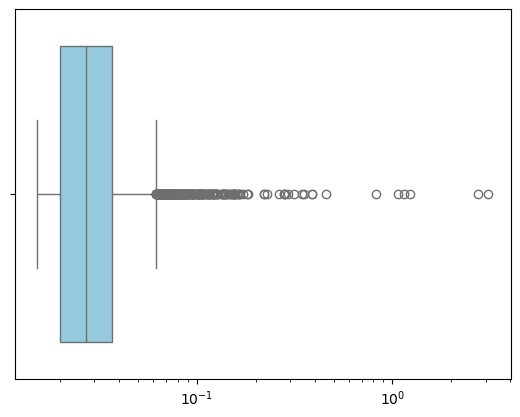

In [15]:
sns.boxplot(x=mean_magnitude, color="skyblue")
plt.xscale('log')

<Axes: >

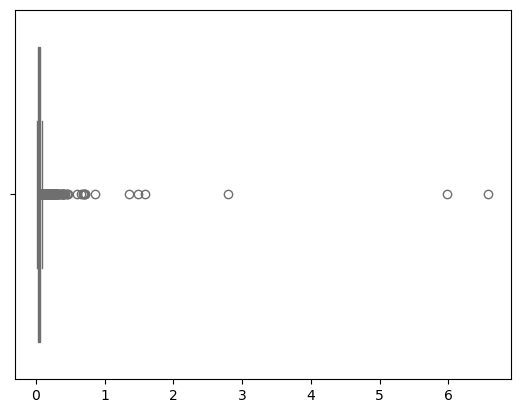

In [13]:
sns.boxplot(x=std, color="skyblue")

<Axes: >

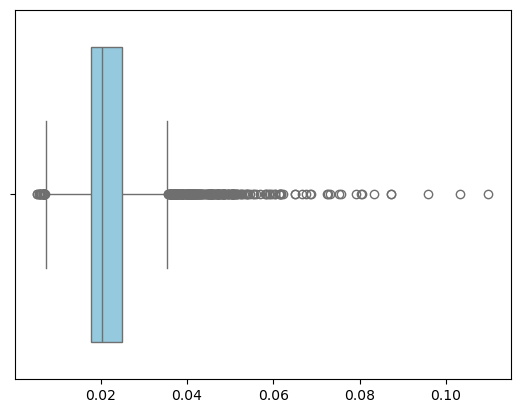

In [12]:
sns.boxplot(x=mean_magnitude_square, color="skyblue")

In [4]:
std_square

array([0.03187834, 0.02971781, 0.02976306, ..., 0.01774497, 0.02795107,
       0.09005047], dtype=float32)

In [7]:
np.mean(std)

0.061298333

In [8]:
np.median(std)

0.042198054

In [5]:
np.mean(std_square)

0.037935164

In [9]:
np.median(std_square)

0.032533936

In [6]:
np.std(std_square)

0.020749388

<Axes: >

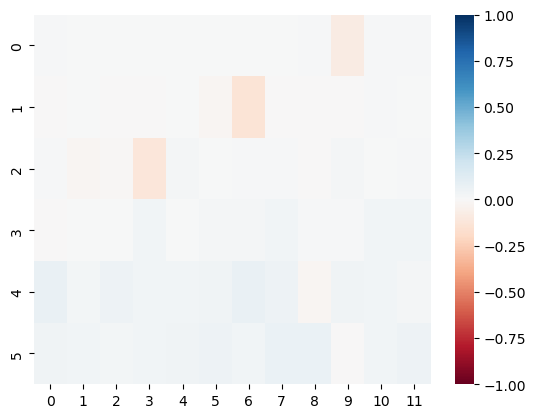

In [7]:
sns.heatmap(
    np.mean(patching_results_normalised, axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

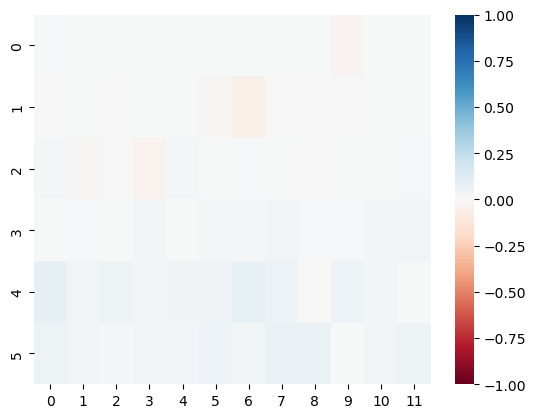

In [8]:
sns.heatmap(
    np.mean(patching_results_normalised[score_difference > 1], axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

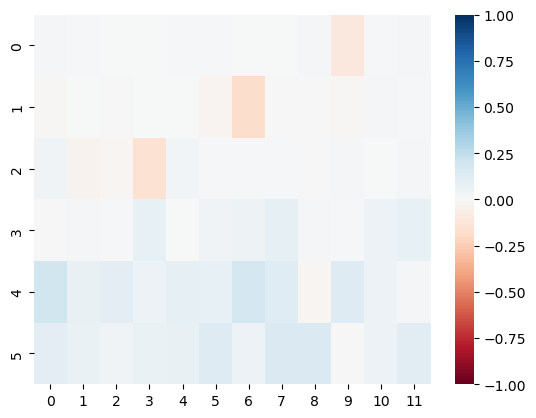

In [9]:
sns.heatmap(
    np.mean(patching_results_normalised_logarithm, axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

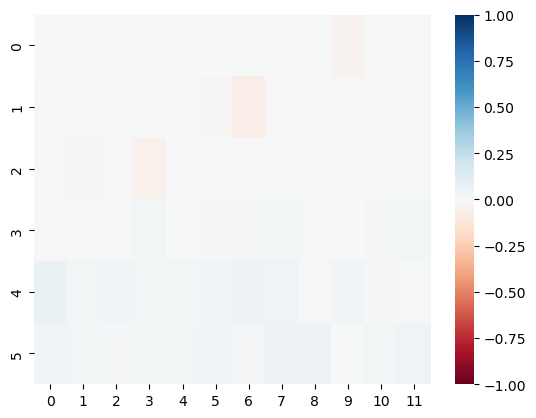

In [10]:
sns.heatmap(
    np.mean(patching_results_normalised_square, axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

/scratch_local/esx208-1127379/tmp/ipykernel_2601747/3379040305.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter_plot = sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude,


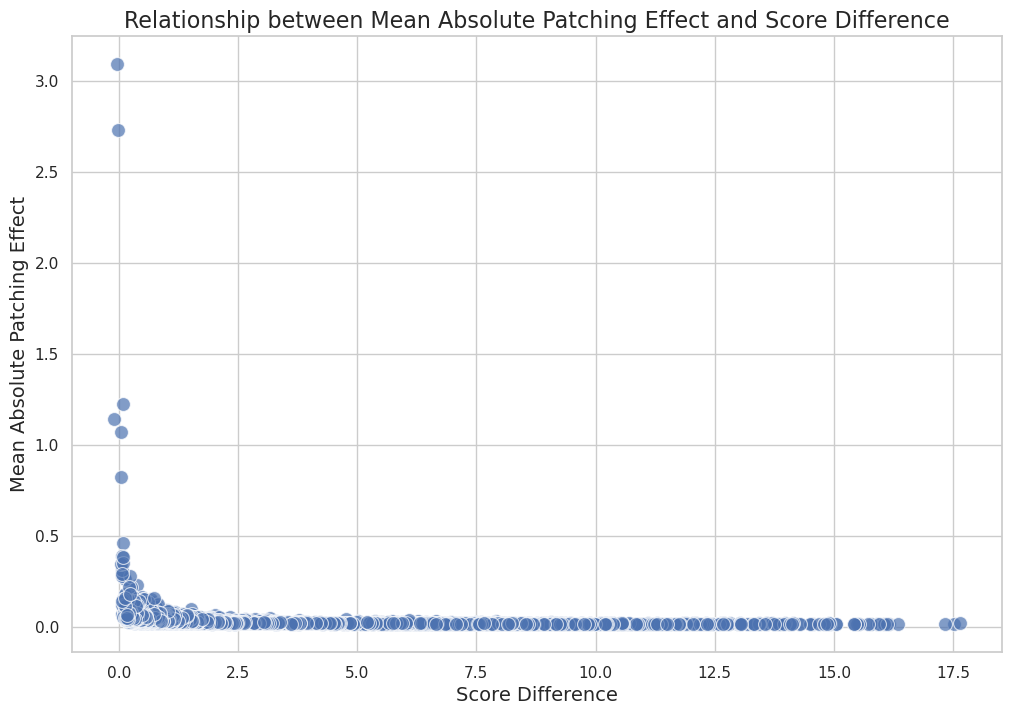

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create improved scatter plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Scatter plot with color palette and transparency
scatter_plot = sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude, 
                               palette='viridis', s=100, alpha=0.7)

# # Add regression line
# sns.regplot(x=score_difference, y=mean_magnitude, scatter=False, color='blue', ax=scatter_plot)

# Customize labels and title
plt.xlabel('Score Difference', fontsize=14)
plt.ylabel('Mean Absolute Patching Effect', fontsize=14)
plt.title('Relationship between Mean Absolute Patching Effect and Score Difference', fontsize=16)

# Add grid
plt.grid(True)

plt.show()

In [21]:
import numpy as np

Q1 = np.percentile(mean_magnitude, 25)
Q3 = np.percentile(mean_magnitude, 75)
IQR = Q3 - Q1

outliers = mean_magnitude[(mean_magnitude < Q1 - 1.5 * IQR) | (mean_magnitude > Q3 + 1.5 * IQR)]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 296


In [22]:
lower_bound = np.percentile(mean_magnitude, 5)
upper_bound = np.percentile(mean_magnitude, 95)

filtered_values = mean_magnitude[(mean_magnitude >= lower_bound) & (mean_magnitude <= upper_bound)]
print(f"Mean before: {np.mean(mean_magnitude)}, Mean after removing outliers: {np.mean(filtered_values)}")

Mean before: 0.03599236533045769, Mean after removing outliers: 0.03005930967628956


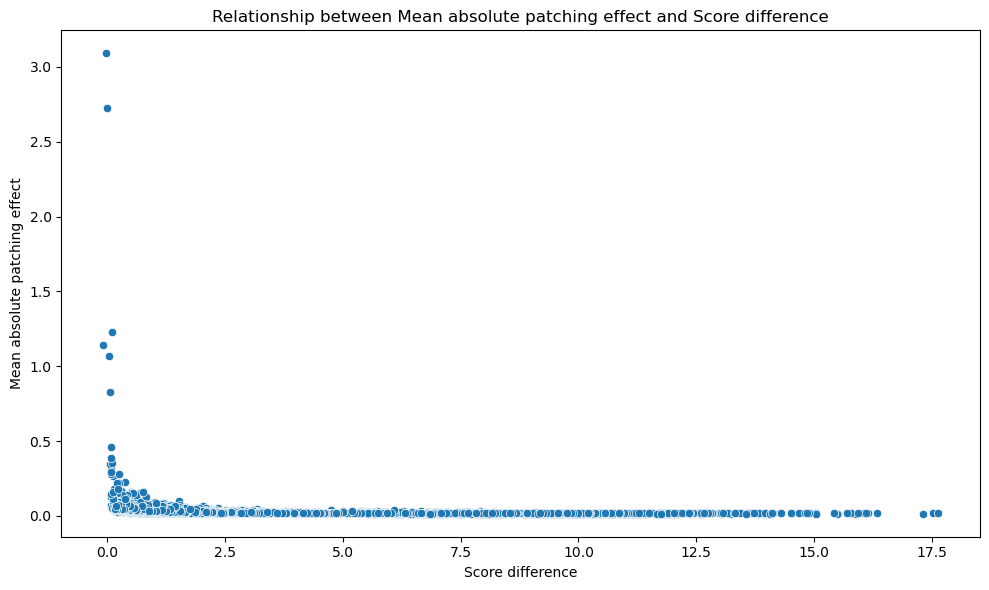

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Relationship between Mean absolute patching effect and Score difference')
plt.tight_layout()
plt.show()

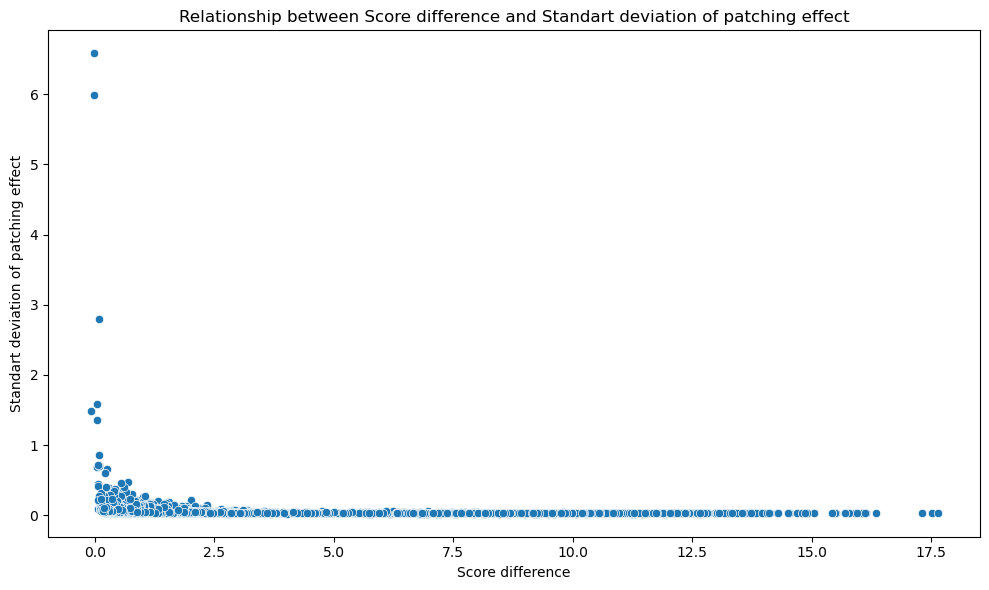

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=std)
plt.xlabel('Score difference')
plt.ylabel('Standart deviation of patching effect')
plt.title(f'Relationship between Score difference and Standart deviation of patching effect')
plt.tight_layout()

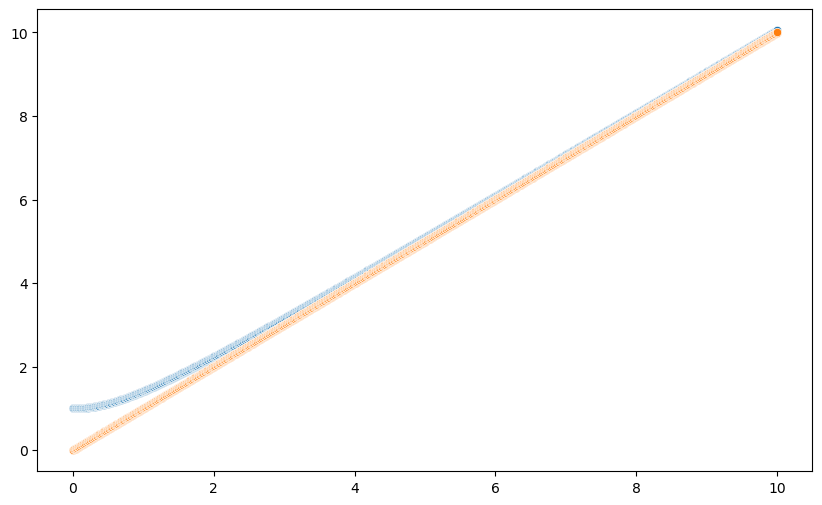

In [13]:
plt.figure(figsize=(10, 6))
x = np.linspace(0, 10, 1000)
sns.scatterplot(x=x, y=np.sqrt(1 + x**2))
sns.scatterplot(x=x, y=x)
plt.show()

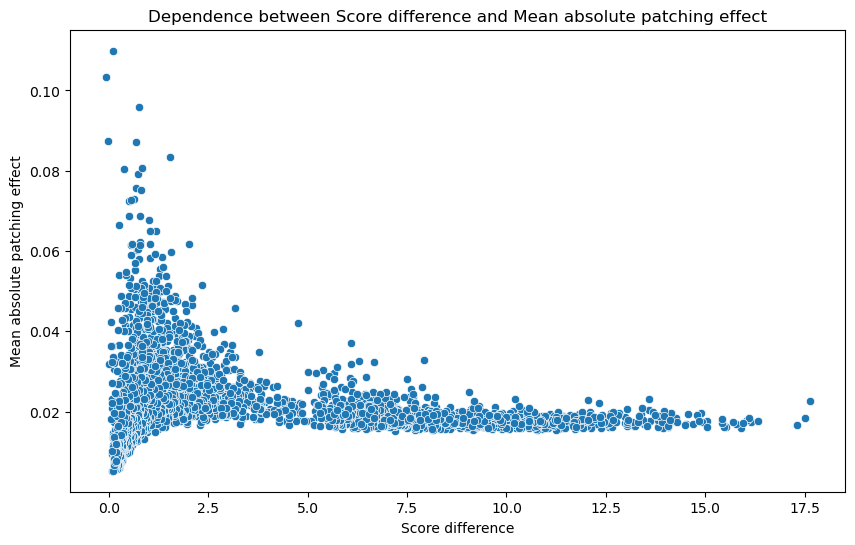

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude_square)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()  

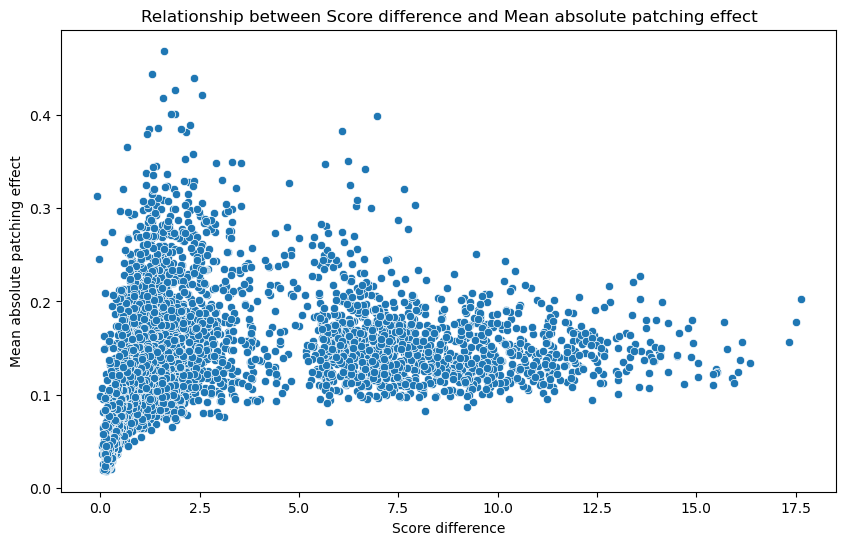

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=max_relative_magnitude_square)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Relationship between Score difference and Mean absolute patching effect')
plt.show()  

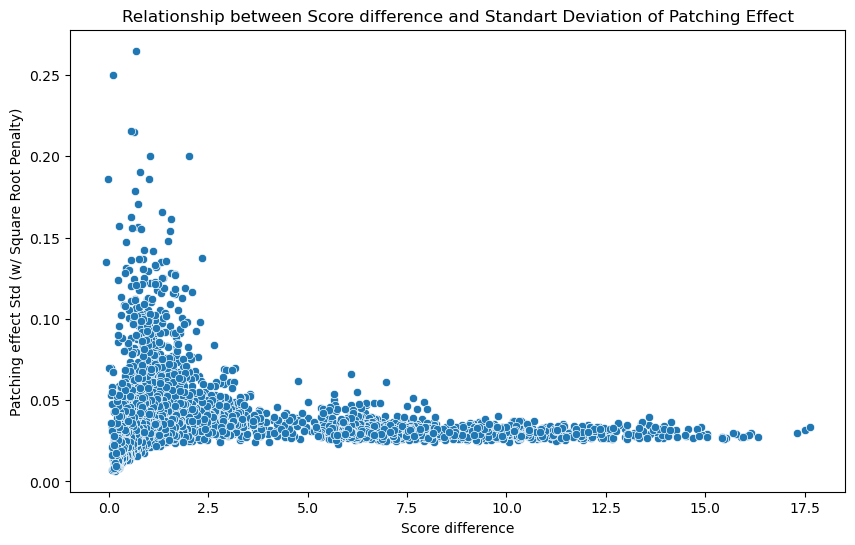

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=std_square)
plt.xlabel('Score difference')
plt.ylabel('Patching effect Std (w/ Square Root Penalty)')
plt.title(f'Relationship between Score difference and Standart Deviation of Patching Effect')
plt.show()  

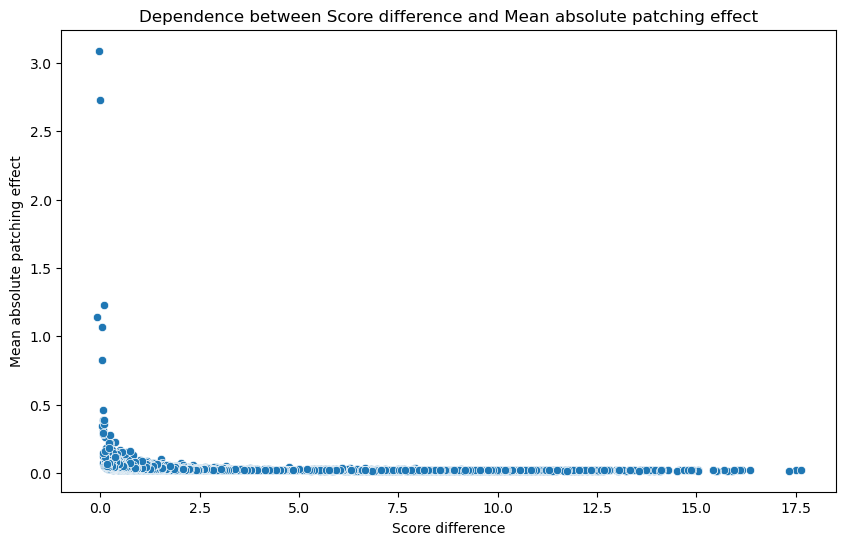

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

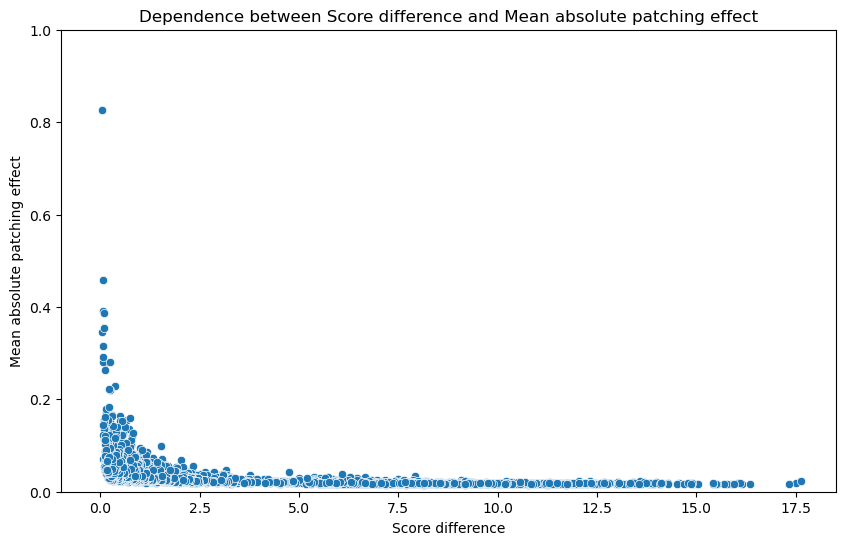

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.ylim(0,1)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

Let's test how does the difference between the patched score and original score depends on the difference between the perturbed score and original score

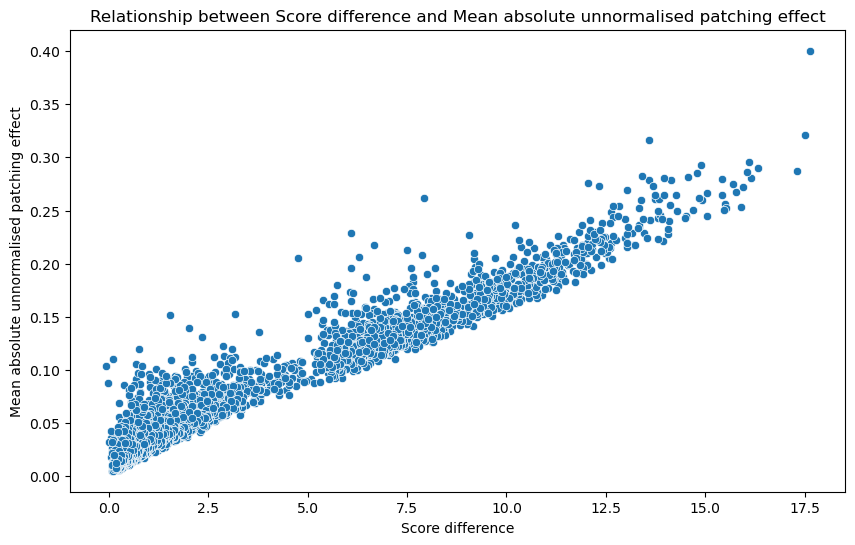

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute unnormalised patching effect')
plt.title(f'Relationship between Score difference and Mean absolute unnormalised patching effect')
plt.show()

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude_unnormalised, hue=all_data_pd['idf_injected_term'])
plt.xlabel('Score difference')
plt.ylabel('Mean absolute unnormalised patching effect')
plt.title(f'Relationship between Score difference and Mean absolute unnormalised patching effect')
plt.show()

KeyError: 'idf_injected_term'

<Figure size 1000x600 with 0 Axes>

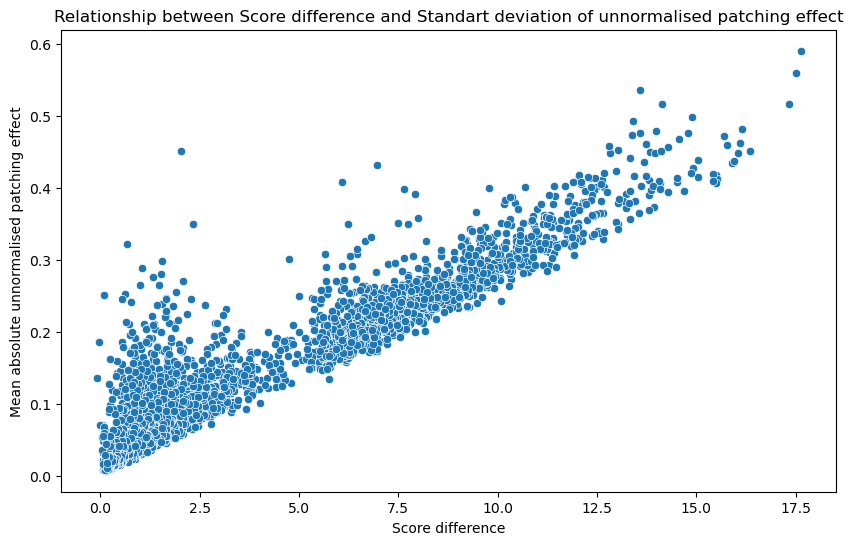

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=std_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute unnormalised patching effect')
plt.title(f'Relationship between Score difference and Standart deviation of unnormalised patching effect')
plt.show()

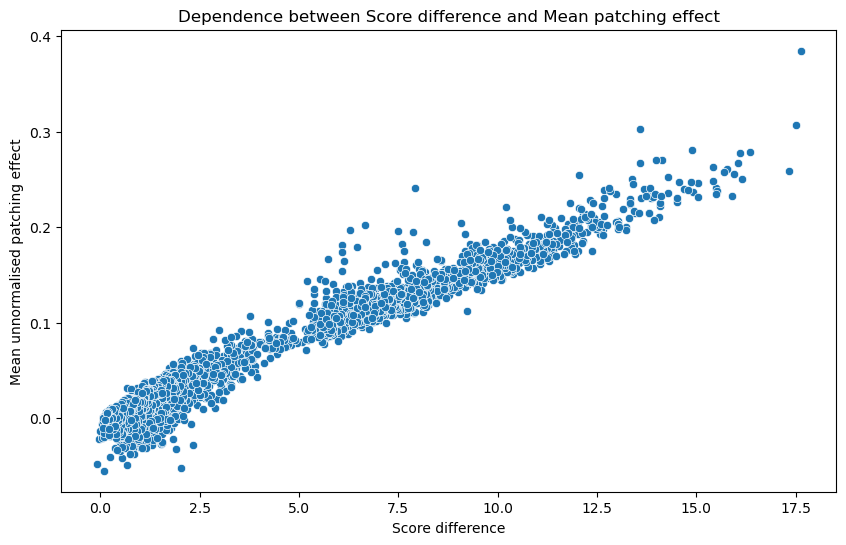

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_relative_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

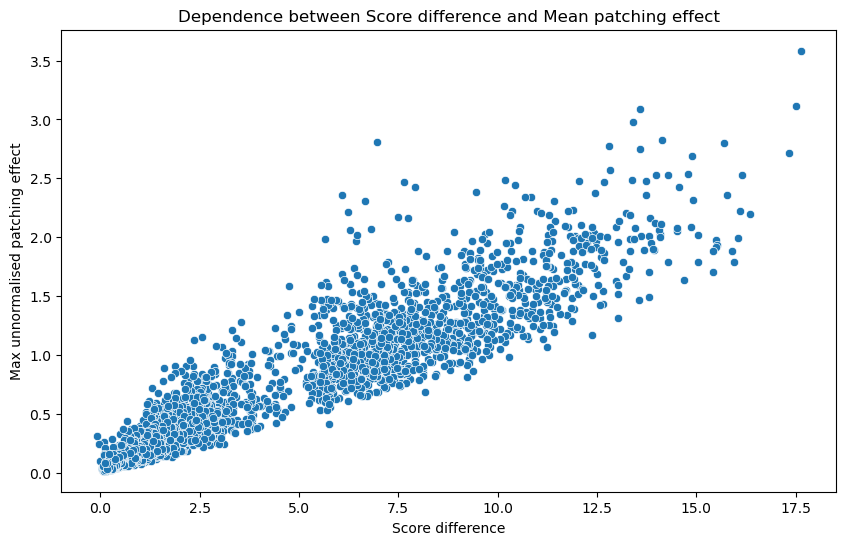

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=max_relative_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Max unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

Let's color these correlation plots according to the qids

In [11]:
qids = all_data_pd['qid'].unique()
colors = plt.cm.get_cmap('tab10', len(qids))
query_color_map = {query: colors(i) for i, query in enumerate(qids)}

/tmp/ipykernel_3806746/1151439420.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(qids))


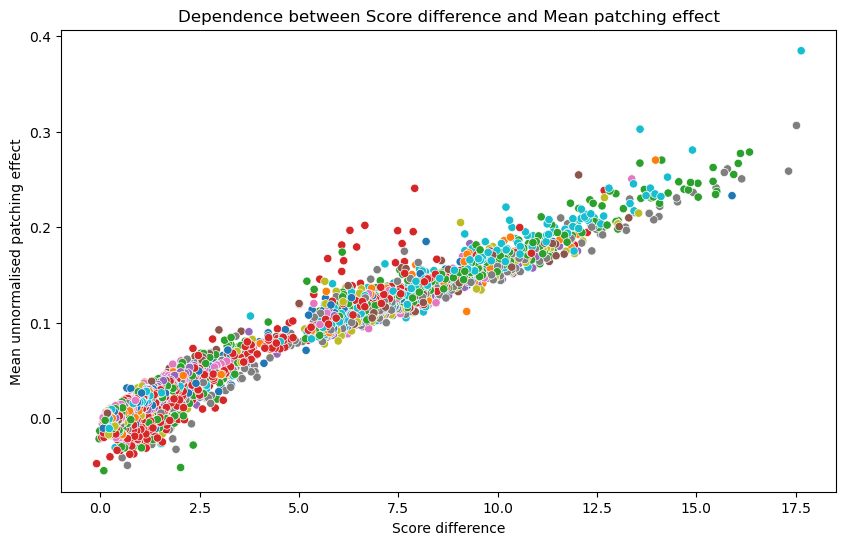

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='mean_relative_magnitude_unnormalised', hue='qid', palette='tab10', legend=False)
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

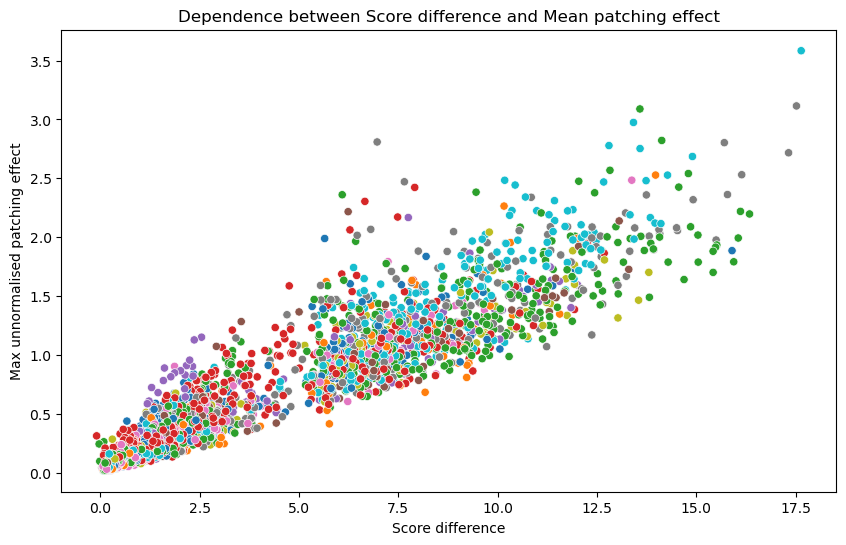

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='max_relative_magnitude_unnormalised', hue='qid', palette='tab10', legend=False)
plt.xlabel('Score difference')
plt.ylabel('Max unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

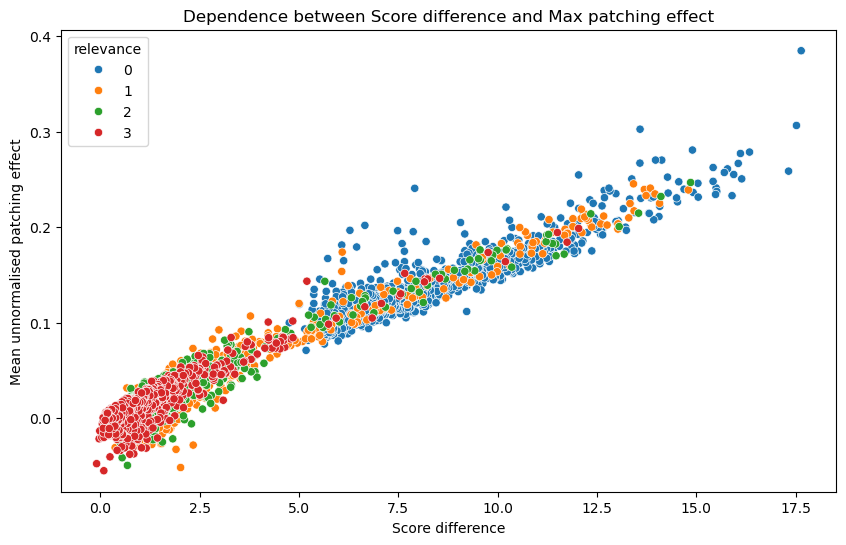

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='mean_relative_magnitude_unnormalised', hue='relevance', palette='tab10')
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Max patching effect')
plt.show()

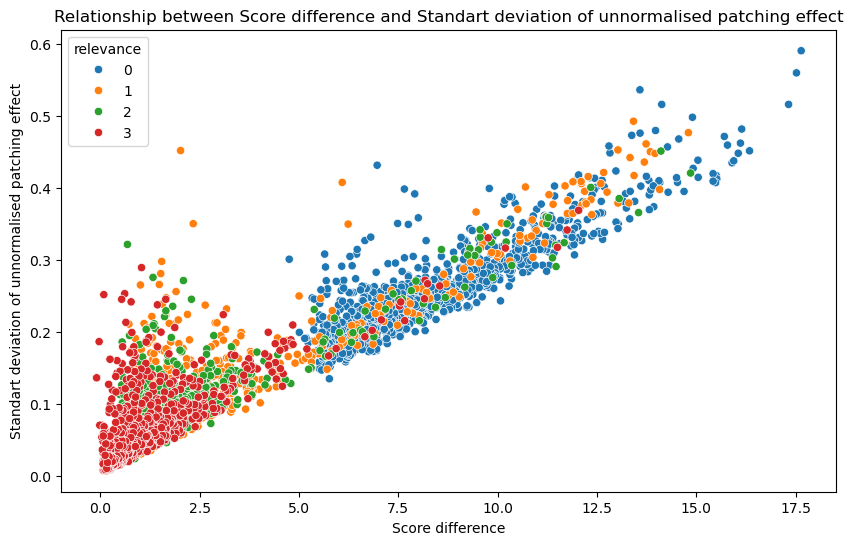

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='std_unnormalised', hue='relevance', palette='tab10')
plt.xlabel('Score difference')
plt.ylabel('Standart deviation of unnormalised patching effect')
plt.title(f'Relationship between Score difference and Standart deviation of unnormalised patching effect')
plt.show()

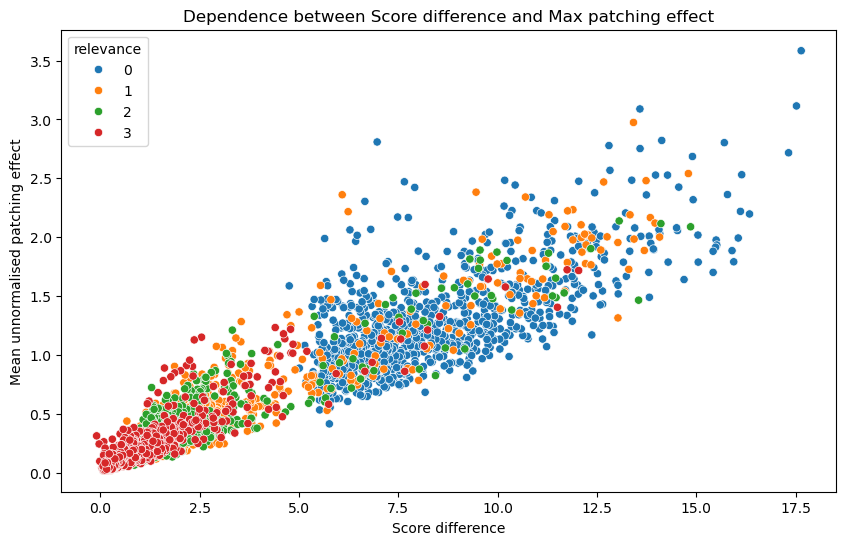

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='max_relative_magnitude_unnormalised', hue='relevance', palette='tab10')
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Max patching effect')
plt.show()

In [29]:
def output_correlations(properties, target_metrics, data):
    correlations = dict()
    for property in properties:
        correlations[property] = dict()
        for target_metric in target_metrics:
            correlation = spearmanr(data[property], data[target_metric])
            correlations[property][target_metric] = correlation
    return correlations



# target_properties = ['score_delta', 'relevance', 'tokenized_doc_length', 'tokenized_query_length', 'original_score', 'perturbed_score', 'injected_term_exists']
# correlation_data = [{'target property': target_property, 
#                      'average absolute patching effect': all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman'),
#                      'average absolute patching effect (duplicate token heads)': all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')} for target_property in target_properties]

# target_metrics = ['mean']

target_properties = ['score_delta', 'relevance']
correlation_data = [{'target property': target_property, 
                     'Std of Patching Effect': all_data_pd[target_property].corr(all_data_pd['std'], method='spearman'), 
                     'Mean Absolute Patching Effect': all_data_pd[target_property].corr(all_data_pd['mean_magnitude'], method='spearman')}
                    for target_property in target_properties]

In [30]:
pd.DataFrame(correlation_data)

,target property,Std of Patching Effect,Mean Absolute Patching Effect
0,score_delta,-0.756595,-0.838204
1,relevance,0.622415,0.675462


In [35]:
target_properties = ['score_delta', 'relevance']
correlation_data = [{'target property': target_property, 
                     'Std of Patching Effect': all_data_pd[target_property].corr(all_data_pd['std_square'], method='spearman'), 
                     'Mean Absolute Patching Effect': all_data_pd[target_property].corr(all_data_pd['mean_magnitude_square'], method='spearman')}
                    for target_property in target_properties]

In [36]:
pd.DataFrame(correlation_data)

,target property,Std of Patching Effect,Mean Absolute Patching Effect
0,score_delta,0.016857,-0.123618
1,relevance,0.042272,0.148068
